## Motion Tests - 8s azimuth oscillation investigation

Author: Ioana Sotuela <br>

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.time import Time, TimeDelta
from lsst_efd_client import EfdClient

import numpy, scipy.optimize

In [2]:
# for tab completion to work in current notebook instance
%config IPCompleter.use_jedi = False

In [3]:
import logging
stream_handler = logging.StreamHandler(sys.stdout)
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [4]:
# Get EFD client and bring in Lupton's unpacking code
client = EfdClient('summit_efd')

Starting new HTTPS connection (1): roundtable.lsst.codes:443


https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253


Starting new HTTPS connection (1): roundtable.lsst.codes:443


https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 177


Starting new HTTPS connection (1): influxdb-summit-efd.lsst.codes:30828


https://influxdb-summit-efd.lsst.codes:30828 "GET /health HTTP/1.1" 200 106


In [ ]:
# Define functions 

In [9]:
def get_period(az_error):
    fs = 100 
    acf = np.correlate(az_error, az_error, 'full')[-len(az_error):]
    inflection = np.diff(np.sign(np.diff(acf))) # 
    peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
    delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value

    signal_freq = fs/delay 
    print(f'Frequency is {signal_freq} Hz')
    period = 1/signal_freq
    print(f'Period is {period} s')

In [51]:
def get_frequency_fft(az_error, times):
    ft = np.fft.rfft(az_error)
    freqs = np.fft.rfftfreq(len(az_error), times[1]-times[0]) # Get frequency axis from the time axis
    mags = abs(ft) 
    plt.plot(freqs, mags)
    plt.xlim(0,0.25)
    plt.show()
    print(f'Frequency is {freqs[mags.argmax()]} \n'
     f'Period is {1/freqs[mags.argmax()]} s')

In [246]:
def fit_sin(times, az_error):
    '''Fit sin to the input az_error time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = (times)
    yy = (az_error)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))  
    Fyy = abs(numpy.fft.fft(yy))
    # Guess parameters for the curve fit. 
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak",
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, 
            "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), 
            "rawres": (guess,popt,pcov)}


# EL 80

In [248]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:27:00", scale='utc')
tend = Time("2022-03-01T19:29:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [249]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))



Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


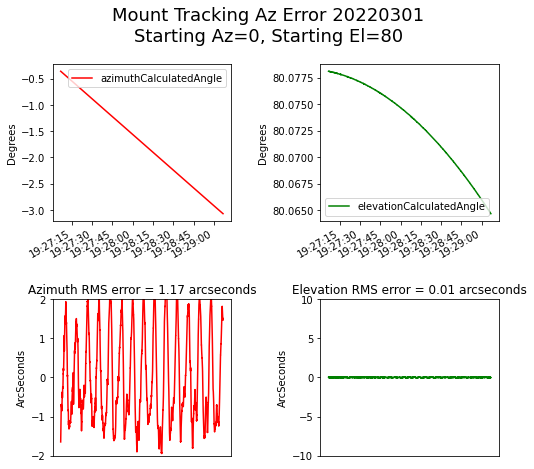

In [250]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220301\nStarting Az=0, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-2.0,2.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el80.pdf")

In [251]:
results_80El = fit_sin(times,az_error)
P80EL = results_80El['period']
A80EL = results_80El['amp']
print(P80EL, A80EL)

8.284581686066366 1.5074089472384413


# El 70 

In [116]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:31:30", scale='utc')
tend = Time("2022-03-01T19:33:30", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [117]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


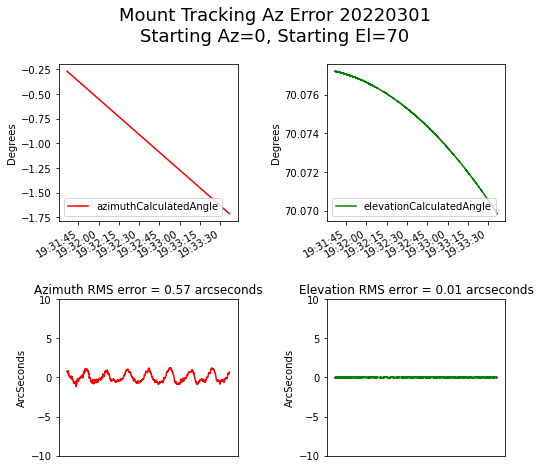

In [118]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220301\nStarting Az=0, Starting El=70", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el70.pdf")

In [120]:
results_70El = fit_sin(times,az_error)
P70EL = results_70El['period']
A70EL = results_70El['amp']
print(P70EL, A70EL)

15.457587223781076 0.733766085187411


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# EL 60 

In [125]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:36:30", scale='utc')
tend = Time("2022-03-01T19:38:30", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [126]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


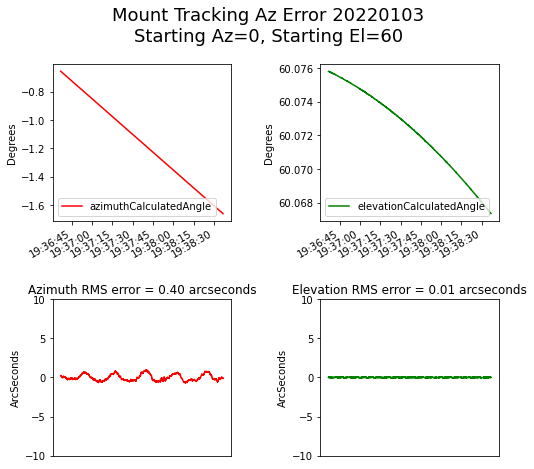

In [127]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=0, Starting El=60", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el60.pdf")

In [128]:
results_60El = fit_sin(times,az_error)
P60EL = results_60El['period']
A60EL = results_60El['amp']
print(P60EL, A60EL)

22.21063708478795 -0.5008680991095928


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# EL 50 

In [129]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:43:00", scale='utc')
tend = Time("2022-03-01T19:45:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [130]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


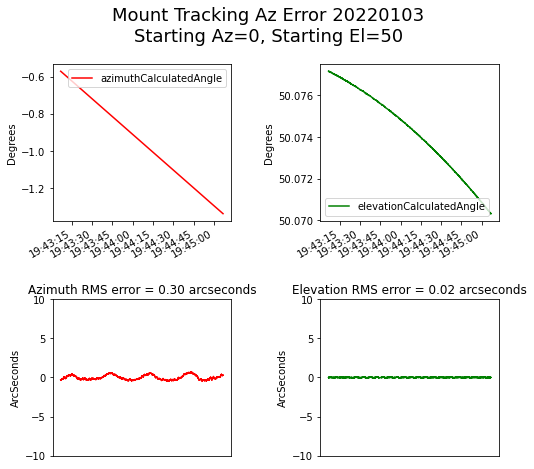

In [131]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=0, Starting El=50", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el50.pdf")

In [132]:
results_50El = fit_sin(times,az_error)
P50EL = results_50El['period']
A50EL = results_50El['amp']
print(P50EL, A50EL)

28.730630060127677 0.37753339407081266


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# El 40 

In [133]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:48:00", scale='utc')
tend = Time("2022-03-01T19:50:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [134]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


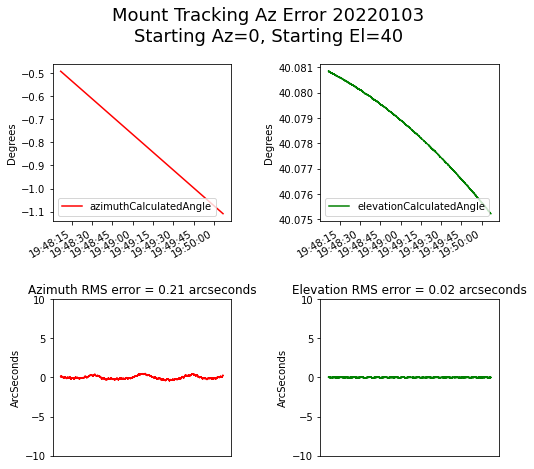

In [135]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=0, Starting El=40", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el40.pdf")

In [136]:
results_40El = fit_sin(times,az_error)
P40EL = results_40El['period']
A40EL = results_40El['amp']
print(P40EL, A40EL)

35.24135626913093 0.229240647101198


# El 25

In [137]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:53:00", scale='utc')
tend = Time("2022-03-01T19:55:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [138]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


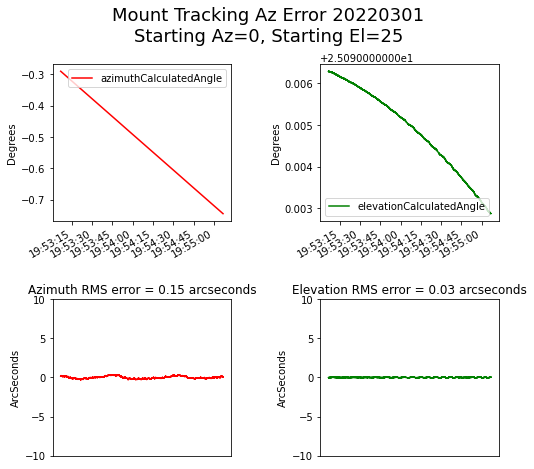

In [139]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220301\nStarting Az=0, Starting El=25", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el25.pdf")

In [140]:
results_25El = fit_sin(times,az_error)
P25EL = results_25El['period']
A25EL = results_25El['amp']
print(P25EL, A25EL)

44.754623438859056 0.1875085303602263


# EL 80 - Back to 80

In [145]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T19:59:30", scale='utc')
tend = Time("2022-03-01T20:01:30", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [146]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


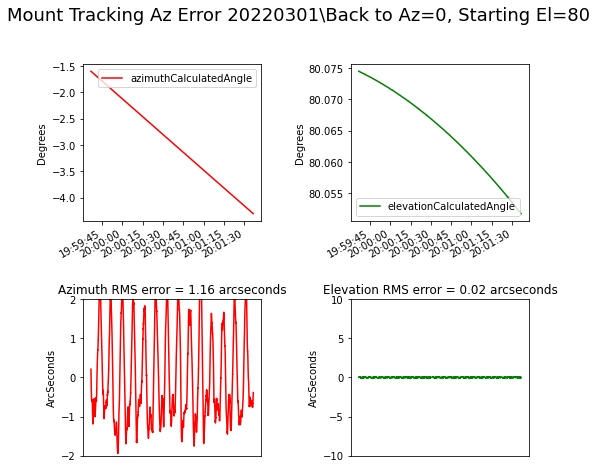

In [150]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220301\Back to Az=0, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-2.0,2.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az0el80_Backto.pdf")

In [149]:
results_80El2 = fit_sin(times,az_error)
P80EL2 = results_80El2['period']
A80EL2 = results_80El2['amp']
print(P80EL2, A80EL2)

8.315267140652006 -1.4614077970575163


# Plot amplitude and period vs elevation (AZ = 0)

In [244]:
Periods = [P80EL, P70EL, P60EL, P50EL, P40EL, P25EL, P80EL2]
print(Periods)
Amplituds = [A80EL, A70EL, abs(A60EL), A50EL, A40EL, A25EL, abs(A80EL2)]
print(Amplituds)
elevation = [80, 70, 60, 50, 40, 25, 80]

[8.284581686066366, 15.457587223781076, 22.21063708478795, 28.730630060127677, 35.24135626913093, 44.754623438859056, 8.315267140652006]
[1.5074089472384413, 0.733766085187411, 0.5008680991095928, 0.37753339407081266, 0.229240647101198, 0.1875085303602263, 1.4614077970575163]


/tmp/ipykernel_57827/3715412919.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xk" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(elevation, Periods, "xk", color='green', markersize=10)
/tmp/ipykernel_57827/3715412919.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*r" (-> color='r'). The keyword argument will take precedence.
  axs[1].plot(elevation, Amplituds, "*r", color = 'blue', markersize=10)


Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


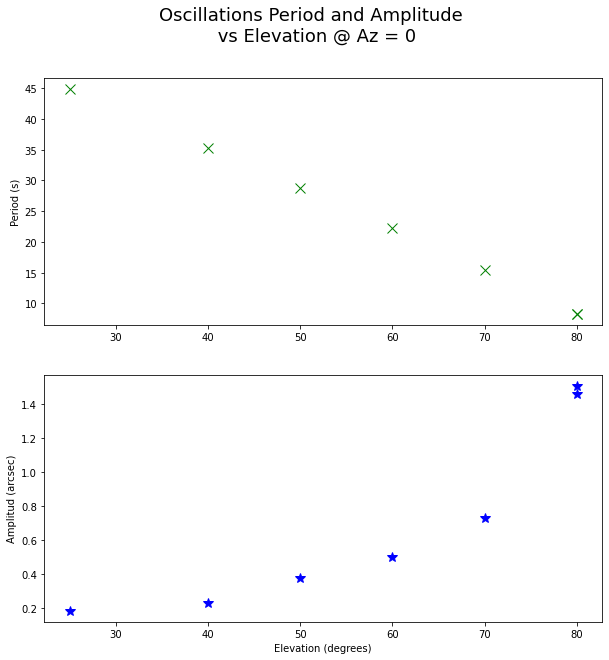

In [245]:
fig, axs = plt.subplots(2,1, figsize = (10,10))
plt.suptitle("Oscillations Period and Amplitude \n vs Elevation @ Az = 0", fontsize = 18)
axs[0].plot(elevation, Periods, "xk", color='green', markersize=10)
axs[0].set_ylabel("Period (s)")
#axs[0].set_xlabel("Elevation (degrees)")

axs[1].plot(elevation, Amplituds, "*r", color = 'blue', markersize=10)
axs[1].set_ylabel("Amplitud (arcsec)")
axs[1].set_xlabel("Elevation (degrees)")
plt.savefig(f"./1Mar22Oscillations_PeriodandAmplitude_vsElevation.pdf")

# Modifying azimuths Az = 10, EL = 80 

In [200]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T20:04:00", scale='utc')
tend = Time("2022-03-01T20:06:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [201]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


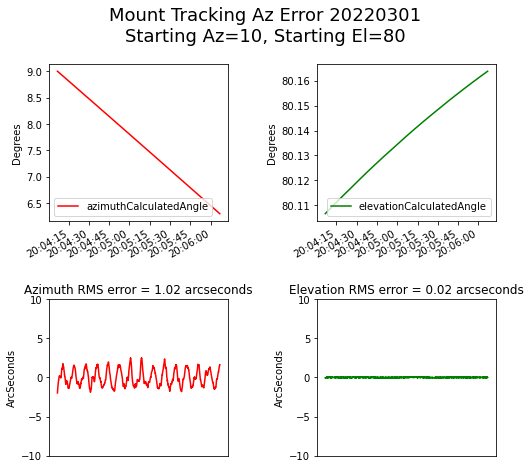

In [202]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220301\nStarting Az=10, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az10el80.pdf")

In [204]:
results_az10 = fit_sin(times,az_error)
P10AZ = results_az10['period']
A10AZ = results_az10['amp']
print(P10AZ, A10AZ)

8.316040298392132 1.3400745814225288


# Az = 20 , EL = 80

In [205]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T20:09:00", scale='utc')
tend = Time("2022-03-01T20:11:00", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [206]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


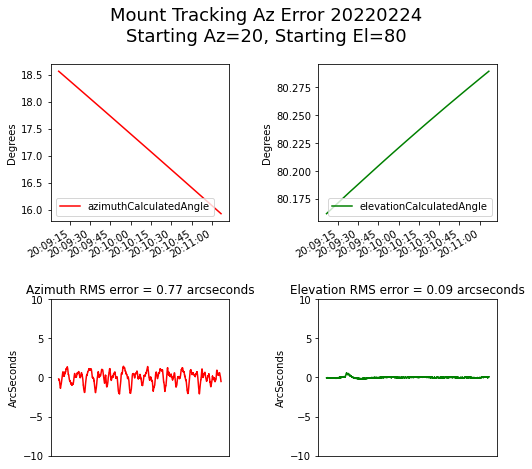

In [207]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220224\nStarting Az=20, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az20el80.pdf")

In [208]:
results_az20 = fit_sin(times,az_error)
P20AZ = results_az20['period']
A20AZ = results_az20['amp']
print(P20AZ, A20AZ)

8.553468553404635 -0.8105962430081847


# Az = 30 , EL = 80

In [209]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T20:14:30", scale='utc')
tend = Time("2022-03-01T20:16:30", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [210]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


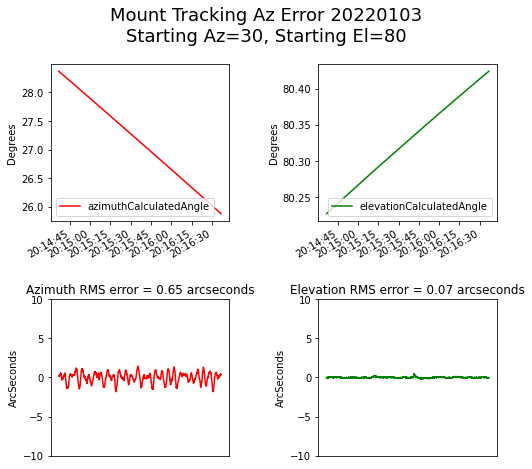

In [211]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=30, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az30el80.pdf")

In [212]:
results_az30 = fit_sin(times,az_error)
P30AZ = results_az30['period']
A30AZ = results_az30['amp']
print(P30AZ, A30AZ)

4.475813042939189 0.6248661350897295


# Az = 45 , EL = 80

In [213]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T20:19:30", scale='utc')
tend = Time("2022-03-01T20:21:30", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [214]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


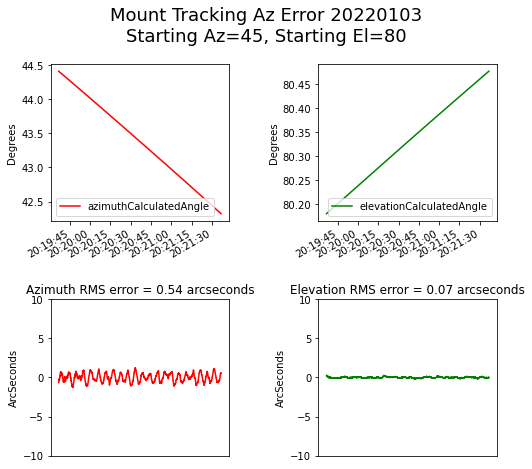

In [215]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=45, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az45el80.pdf")

In [216]:
results_az45 = fit_sin(times,az_error)
P45AZ = results_az45['period']
A45AZ = results_az45['amp']
print(P45AZ, A45AZ)

5.386934735242924 0.6218192725874065


# Az = 60 , EL = 80

In [217]:
# Blow up the first two minutes to look at the periodic error
tstart = Time("2022-03-01T20:24:30", scale='utc')
tend = Time("2022-03-01T20:25:10", scale='utc')
az = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "azimuthCalculatedAngle",  tstart, tend)
el = await client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", "elevationCalculatedAngle",  tstart, tend)


200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT azimuthCalculatedAngle0, azimuthCalculatedAngle1, azimuthCalculatedAngle2, azimuthCalculatedAngle3, azimuthCalculatedAngle4, azimuthCalculatedAngle5, azimuthCalculatedAngle6, azimuthCalculatedAngle7, azimuthCalculatedAngle8, azimuthCalculatedAngle9, azimuthCalculatedAngle10, azimuthCalculatedAngle11, azimuthCalculatedAngle12, azimuthCalculatedAngle13, azimuthCalculatedAngle14, azimuthCalculatedAngle15, azimuthCalculatedAngle16, azimuthCalculatedAngle17, azimuthCalculatedAngle18, azimuthCalculatedAngle19, azimuthCalculatedAngle20, azimuthCalculatedAngle21, azimuthCalculatedAngle22, azimuthCalculatedAngle23, azimuthCalculatedAngle24, azimuthCalculatedAngle25, azimuthCalculatedAngle26, azimuthCalculatedAngle27, azimuthCalculatedAngle28, azimuthCalculatedAngle29, azimuthCalculatedAngle30, azimuthCalculatedAngle31, azimuthCalculatedAngle32, azimuthCalculatedAngle33, azimuthCalculatedAngle34, azimuthCalculatedAngle35, azimuthCalculatedAngle36, azimuthCalculatedAngle37, azimuthCal

200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"


200: SELECT elevationCalculatedAngle0, elevationCalculatedAngle1, elevationCalculatedAngle2, elevationCalculatedAngle3, elevationCalculatedAngle4, elevationCalculatedAngle5, elevationCalculatedAngle6, elevationCalculatedAngle7, elevationCalculatedAngle8, elevationCalculatedAngle9, elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, elevationCalculatedAngle20, elevationCalculatedAngle21, elevationCalculatedAngle22, elevationCalculatedAngle23, elevationCalculatedAngle24, elevationCalculatedAngle25, elevationCalculatedAngle26, elevationCalculatedAngle27, elevationCalculatedAngle28, elevationCalculatedAngle29, elevationCalculatedAngle30, elevationCalculatedAngle31, elevationCalculatedAngle32, elevationCalculatedAngle33, elevationCalculatedAngle34, elevationCalculate

In [218]:
# Calculate the tracking errors
az_vals = np.array(az.values.tolist())[:,0]
el_vals = np.array(el.values.tolist())[:,0]
times = np.array(az.values.tolist())[:,1]
times = times - times [0]

# Fit with a quartic
az_fit = np.polyfit(times, az_vals, 4)
el_fit = np.polyfit(times, el_vals, 4)

az_model = az_fit[0] * times * times * times * times + az_fit[1] * times * times * times \
    + az_fit[2] * times *times + az_fit[3] * times + az_fit[4]
el_model = el_fit[0] * times * times * times * times + el_fit[1] * times * times * times \
    + el_fit[2] * times * times + el_fit[3] * times + el_fit[4]

# Errors in arcseconds
az_error = (az_vals - az_model) * 3600
el_error = (el_vals - el_model) * 3600

# Calculate RMS
az_rms = np.sqrt(np.mean(az_error * az_error))
el_rms = np.sqrt(np.mean(el_error * el_error))

Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


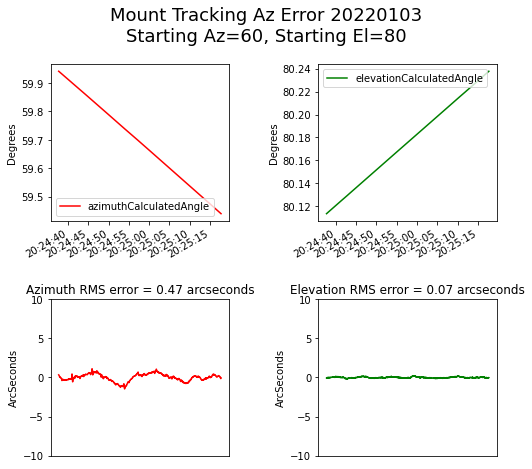

In [219]:
# Plot it
fig = plt.figure(figsize = (8,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle(f"Mount Tracking Az Error 20220103\nStarting Az=60, Starting El=80", fontsize = 18)
plt.subplot(2,2,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_ylabel("Degrees")
plt.subplot(2,2,2)
ax3 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax3.set_ylabel("Degrees")

plt.subplot(2,2,3)
plt.plot(times, az_error, color='red')
plt.title(f"Azimuth RMS error = {az_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.subplot(2,2,4)
plt.plot(times, el_error, color='green')
plt.title(f"Elevation RMS error = {el_rms:.2f} arcseconds")
plt.ylim(-10.0,10.0)
plt.xticks([])
plt.ylabel("ArcSeconds")
plt.savefig(f"./Az_Error_Debug_1_1Mar22_az60el80.pdf")

In [220]:
results_az60 = fit_sin(times,az_error)
P60AZ = results_az60['period']
A60AZ = results_az60['amp']
print(P60AZ, A60AZ)

16.14631655157584 -0.5423241874101729


# Plot amplitude and period vs azimuth (EL = 80) 

In [242]:
Periods2 = [P10AZ, P20AZ, P30AZ, P45AZ, P80EL2]
print(Periods2)
Amplituds2 = [A10AZ, abs(A20AZ), A30AZ, A45AZ, abs(A80EL2)]
print(Amplituds2)
azimuth = [10, 20, 30, 45, 0]

[8.316040298392132, 8.553468553404635, 4.475813042939189, 5.386934735242924, 8.315267140652006]
[1.3400745814225288, 0.8105962430081847, 0.6248661350897295, 0.6218192725874065, 1.4614077970575163]


/tmp/ipykernel_57827/3661609029.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xk" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(azimuth, Periods2, "xk", color='green', markersize=10)
/tmp/ipykernel_57827/3661609029.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "*r" (-> color='r'). The keyword argument will take precedence.
  axs[1].plot(azimuth, Amplituds2, "*r", color = 'blue', markersize=10)


Assigning font /b'F1' = '/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


Embedding font /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-1.0.0/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.


Writing TrueType font.


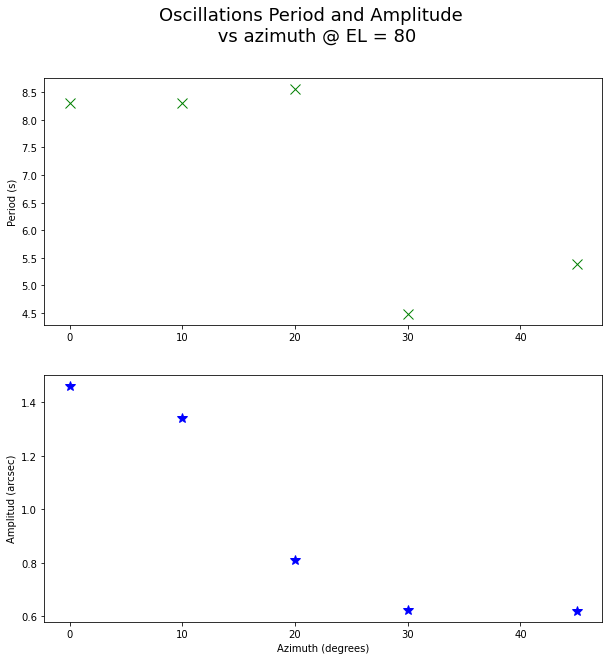

In [243]:
fig, axs = plt.subplots(2,1, figsize = (10,10))
plt.suptitle("Oscillations Period and Amplitude \n vs azimuth @ EL = 80", fontsize = 18)
axs[0].plot(azimuth, Periods2, "xk", color='green', markersize=10)
axs[0].set_ylabel("Period (s)")
#axs[0].set_xlabel("Elevation (degrees)")

axs[1].plot(azimuth, Amplituds2, "*r", color = 'blue', markersize=10)
axs[1].set_ylabel("Amplitud (arcsec)")
axs[1].set_xlabel("Azimuth (degrees)")
plt.savefig(f"./1Mar22Oscillations_PeriodandAmplitude_vsAzimuth.pdf")